# Expectation Maximization for Gaussian Mixture Models

In this notebook we'll do a simple implementation of the Expectation Maximization algorithm for estimating unknown parameters in a Gaussian Mixture Model.

As a quick review, a Gaussian mixture model is a linear combination of Gaussians, we consider a stochastic process that generates samples in $\mathbb{R}$, similar to a univariate distribution. The difference is that in a mixture model we assume that the samples are drawn from a set of $k$ mixtures. For each sample the mixture weights define the probability that the sample was drawn from each of the underlying distributions.

More formally, 

Given a finite set of probability density functions $p_1(x), ..., p_n(x)$, or corresponding cumulative distribution functions $P_1(x), ... , P_n(x)$ and weights $\pi_1, …, \pi_n$ such that $\pi_i \geq 0$ and $\Sigma \pi_i = 1$, the mixture distribution can be represented by writing either the density, f, or the distribution function, F, as a sum (which in both cases is a convex combination):

$${\displaystyle F(x)=\sum _{i=1}^{n}\,\pi_{i}\,P_{i}(x),}$$

$${\displaystyle f(x)=\sum _{i=1}^{n}\,\pi_{i}\,p_{i}(x).}$$

This type of mixture, being a finite sum, is called a finite mixture, and in applications, an unqualified reference to a "mixture density" usually means a finite mixture. The case of a countably infinite set of components is covered formally by allowing ${\displaystyle n=\infty \!}$.

In this notebook we'll work with a specific type of mixture model, a **Gaussian Mixture Model**, that consists of a linear combination of Gaussians.

## Imports

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import pandas as pd
from math import sqrt, log, exp, pi
from random import uniform
sns.set_style("white")
%matplotlib inline

## Define the Gaussian Mixture Model

Lets define a Gaussian mixture model that we'll use later on for estimating the parameters of using EM. Of course since we create the model ourselves, we already know the parameters, the we simply want to test out whether we can also estimate them using EM and a data sample.

$$\mu_1 = 1, \sigma_1 = 4, \pi_1 = 0.65$$
$$\mu_1 = 2, \sigma_2 = 10, \pi_2 = 0.35$$

In [2]:
mu_1 = 1.0
sigma_1 = 4.0 
pi_1 = 0.65
mu_2 = 10.0
sigma_2 = 2.0
pi_2 = 0.35

### Sample and Plot

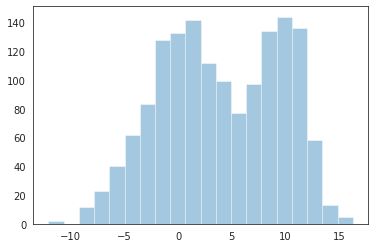

In [4]:
sample_1 = np.random.normal(mu_1, sigma_1, int(1500*pi_1))
sample_2 = np.random.normal(mu_2, sigma_2, int(1500*pi_2))
total_sample=np.append(sample_1,sample_2)
x = np.linspace(min(total_sample), max(total_sample), 2000)
sns.distplot(total_sample, bins=20, kde=False)

## Try fit the data with a single Gaussian

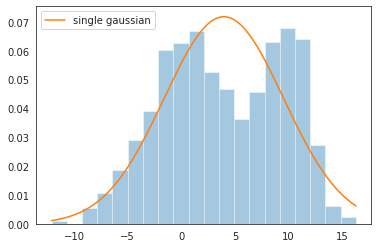

In [5]:
gaussian = stats.norm(np.mean(total_sample), np.std(total_sample)).pdf(x)
sns.distplot(total_sample, bins=20, kde=False, norm_hist=True)
plt.plot(x, gaussian, label='single gaussian')
plt.legend()

## Implement EM to fit the GMM 

Expectation Maximization is a useful estimator when the data is only partially observed. A GMM can be modeled as a partially observed distribution as the mixture identities of the data is not observed. That is, the mixture components are latent variables in the GMM.

That is, lets consider $k=2$ univariate Gaussian distributions with resepctive density functions $f_1, f_2$ and respective parameters $(\mu_1, \sigma_1), (\mu_2, \sigma_2)$. Let $\pi_1, \pi_2$ be a probability distribution on $\{1, 2\}$. Then a sample from the mixture model can be seen as:
$$X \sim \mathcal{\mu_z, \sigma_z} : \quad Z \sim \pi$$

This can also be modeled as a joint distribution $f_{X,Z}(x,z)$. The vector $X$ has density: 
$$p_{\theta}(x) = \sum_{j=1}^{k=2}\pi_j f_j(x)$$

For regular gaussian distributions, the maximum likelihood estimator is usually applied. For $n$ samples $x_1, ..., x_n$, the likelihood function is:
$$L(\theta) = \prod_{i=1}^{n} p_{\theta}(x_i)$$

and the log likelihood function is:

$$\log L(\theta) = \log\left(\prod_{i=1}^{n} p_{\theta}(x_i)\right)$$
$$ = \sum_{i=1}^{n} \log p_{\theta}(x_i)$$

For the gaussian mixture model we have that $p_{\theta}(x_i) = \sum_{j=1}^{k}\pi_j f_j(x)$ which means that the log likelihood becomes:

$$\log L(\theta) = \sum_{i=1}^{n} \log \left(\sum_{j=1}^{k}\pi_j f_j(x) \right)$$

the maximum likelihood estimator is then:
$$\theta^{*} = argmax_{\theta} \log L(\theta)$$

However due to the sum $\sum_{j=1}^{k}$ inside the log of the likelihood function this is typically a much harder problem to solve in closed form than the maximum likelihood estimation for a regular univariate Gaussian.

Thus, we will instead use an iterative algorithm, called Expectation Maximization (EM) to estimate the paramters of the GMM. 

The insight of EM is that if the mixture components $z_1, ..., z_n$ associated with each data sample $x_1, ..., x_n$ were observed, then the likelihood estimation of the unknown parameters $\theta$ would be much easier. 

EM works as follows. Firstly, we model the mixture components as latent variables $z$, meaning that we are now considering a joint distribution $p_{\theta}(x, z)$. While it is a joint distribution we are still mostly interested in the marginal $p_{\theta}(x)$ as that is what we need to do the ML-estimation. 

We can decompose the joint distribution as:

$$p_{\theta}(x,z) = P(x|z) \cdot p(z)$$

where, 

$$p_{\theta}(z) = \prod_{i=1}^{n} p_{\theta}({z_i}) = \prod_{i=1}^{n} \pi_ {z_i}$$

and,

$$p_{\theta}(x|z) = \prod_{i=1}^{n} p_{\theta}(x_i | z_i) = \prod_{i=1}^{n} f_{z_i}(x_i)$$

Now it becomes clear that if the latent variables $z$ were observed, then the likelihood function would becomes simple. That is, the original likelihood function:

$$\log L(\theta) = \sum_{i=1}^{n} \log \left(\sum_{j=1}^{k}\pi_j f_j(x) \right)$$

becomes:

$$\log L(\theta) = \sum_{i=1}^{n} \log \left(\pi_{z_i} \cdot f_{z_i}(x_i)\right)$$
$$ = \sum_{i=1}^{n} \log \pi_{z_i} + \log f_{z_i}(x_i)$$
$$ = \sum_{i=1}^{n} \log \pi_{z_i} + \sum_{i=1}^{n} \log f_{z_i}(x_i)$$

However the problem is of course that we do **not** know observe the mixture components $z_i$. What EM does to get around this is to "guess" or estimate the **mixture weights** $\hat{\pi}_j$ and use those mixture weights to calculate the **expected** joint distribution over $x$ and $z$ (the E-step) and then use regular maximum likelihood estimation to calculate $\theta$ that maximizes the expected log likelihood (the M-step).

So to figure out how to compute the expected log likelihood, lets recall the the data distribution we are working with when modeling the GMM with latent variables:

$$p_{\theta}(x,z) = \prod_{i=1}^{n} \pi_{z_i} f_{z_i}(x_i)$$

We now want to compute $\mathbb{E}[p_{\theta}(x,z)]$ given the observed values of $x$ as well as a guess for the parameters $\theta_0$ that includes a guess of the mixture weights $\hat{\pi}_j$, that is we are interested in: $\mathbb{E}[p_{\theta}(x,z) | \theta_0, x]$. Treating $\theta_0$ and $x$ as given, the only random variable for this expectation is $p_{\theta}(z | x, \theta_0)$. 

We have that:

$$p_{\theta}(z | x ) = \prod_{i=1}^{n} p_{\theta}(z_i | x_i)$$
$$ = \prod_{i=1}^{n} \frac{p_{\theta}(z_i, x_i)}{p_{\theta}(x_i)}$$

where $p_{\theta}(x_i)$ in the denominator is an normalizing constant and we have that:

$$p_{\theta}(z | x ) \propto \prod_{i=1}^{n} p_{\theta}(z_i, x_i)$$
$$ = \prod_{i=1}^{n} \pi_{z_i} f_{z_i}(x_i)$$

That is, the probability that sample $i$ comes from mixture $j$ is:
$$p_{i,j} \propto \pi_j \cdot f_j (x_i)$$

Recall the expectation formula:

$$\mathbb{E}_x[f(x)] = \int f(x) \cdot p_{x}(x) dx$$

or in the discrete case:

$$\sum_x f(x) \cdot p_x(x)$$

Given the observed data $x$ and our initial guess of $\theta_0$ and $\hat{\pi}_j$ we obtain a distribution that we can use to calculate $\mathbb{E}[p_{\theta}(x,z) | \theta_0, x]$ (as $x$ and $\theta_0$ are treated as constants rather than random variables here, we only have to integrate over $z$:

$$\mathbb{E}[p_{\theta}(x,z) | \theta_0, x] = \int p_{\theta}(x,z) \cdot f(z | x, \theta_0) dz$$
$$= \sum_{j=1}^{k} p_{\theta}(x, z_j) \cdot p(z_j | x, \theta_0)$$
$$= \sum_{j=1}^{k}\sum_{i=1}^{n} p_{\theta}(x_i, z_j) \cdot p(z_j | x_i, \theta_0)$$

As usual, we take the logarithm of the likelihood:

$$= \sum_{j=1}^{k}\sum_{i=1}^{n} p_{\theta}(x_i, z_j) \cdot \log p(z_j | x_i, \theta_0)$$
$$= \sum_{j=1}^{k}\sum_{i=1}^{n} p_{\theta}(x_i, z_j) \cdot \log (\pi_{j,\theta_0} \cdot f_{j,\theta_0}(x_i))$$
$$= \sum_{j=1}^{k}\sum_{i=1}^{n} p_{\theta}(x_i, z_j) \cdot (\log \pi_{j,\theta_0} + \log f_{j,\theta_0}(x_i))$$

Now when we have derived the expected log likelihood we can see that this likelihood function we can maximize with MLE quite easily as the mixture weights and Gaussian parameters are given by $\theta_0$ the densities can be calculated for $x$ 

The MLE estimate is obtained by differentiating the likelihood function and equating it to zero and solving for $\theta$. In the case where $\theta$ are paramters of a Gaussian the MLE is simply the empirical mean, standard deviations and mixture weights.

Once the MLE estimate have been computed we set $\theta_1$ to be the MLE estimate and iterate.

In [15]:
def em(sample, n_iterations):
    
    # Initial guess of Theta_0
    mu_1 = np.random.choice(sample, 1)
    mu_2 = np.random.choice(sample, 1)
    std_1 = np.std(sample)/1
    std_2 = np.std(sample)/2
    pi_1 = 1
    pi_2 = 1
    
    # Iterative estimation
    for it in range(n_iterations):
        
        # Logging
        if it % 100 == 0:
            print("iteration: {}".format(it))
            print("mu_1: {}, mu_2: {}, std_1:{}, std_2:{}, pi_1: {}, pi_2: {}".format(mu_1, mu_2, std_1, std_2, pi_1, pi_2))
        
        
        # E-step: compute the expected log likelihoods for each data point x_i 
        pijs = []
        for i in range(len(sample)):
            # Use observed data and guess of Theta_0 to compute (p(z_j | x_i, \theta_0)) for all j and i
            
            s = 0
            pij_1 = pi_1*(1/(std_1*sqrt(2*np.pi)))*np.exp((-1/2)* pow(((sample[i]-mu_1)/std_1), 2))
            pij_2 = pi_2*(1/(std_2*sqrt(2*np.pi)))*np.exp((-1/2)* pow(((sample[i]-mu_2)/std_2), 2))
            
            s = pij_1 + pij_2

            pij_1 = pij_1/s
            pij_2 = pij_2/s

            pijs.append([pij_1, pij_2])
        
        # M-step, maximize theta_1 with respect to the expected log_likelihoods 
        # (no differentiation is necessary as maxima is equal to the empirical mean, std, and mixture weight)
        pi_1 = 0
        pi_2 = 0
        mu_1 = 0
        mu_2 = 0

        for i in range(len(sample)):
            pi_1 = pi_1 + pijs[i][0]
            pi_2 = pi_2 + pijs[i][1]
            mu_1 = mu_1 + pijs[i][0]*sample[i]
            mu_2 = mu_2 + pijs[i][1]*sample[i]
            
        # Arithmethic mean of the sample data given the estimated mixture counts
        mu_1 = mu_1/pi_1
        mu_2 = mu_2/pi_2

        std_1 = 0
        std_2 = 0

        for i in range(len(sample)):
            std_1 = std_1 + pijs[i][0]* pow((sample[i] - mu_1), 2)
            std_2 = std_2 + pijs[i][1]* pow((sample[i] - mu_2), 2)
        
        # Standard error given the arithmetic means and estimated mixture counts
        std_1 = sqrt(std_1 / pi_1)
        std_2 = sqrt(std_2 / pi_2)
        
        # Normalize mixture counts into probabilities
        pi_1 = pi_1/len(sample)
        pi_2 = pi_2/len(sample)
        
    return mu_1, mu_2, std_1, std_2, pi_1, pi_2

In [16]:
mu_1, mu_2, std_1, std_2, pi_1, pi_2 = em(total_sample, 1000)

iteration: 0
mu_1: [-2.58184348], mu_2: [-1.02884935], std_1:5.558732427896689, std_2:2.7793662139483444, pi_1: 1, pi_2: 1
iteration: 100
mu_1: [9.91774358], mu_2: [0.68884706], std_1:2.004476866808404, std_2:3.931744638105659, pi_1: [0.35499656], pi_2: [0.64500344]
iteration: 200
mu_1: [9.91802481], mu_2: [0.68930597], std_1:2.004297343588469, std_2:3.9320551820672645, pi_1: [0.35495367], pi_2: [0.64504633]
iteration: 300
mu_1: [9.91802482], mu_2: [0.68930598], std_1:2.004297339115232, std_2:3.932055189806834, pi_1: [0.35495367], pi_2: [0.64504633]
iteration: 400
mu_1: [9.91802482], mu_2: [0.68930598], std_1:2.00429733911512, std_2:3.9320551898070275, pi_1: [0.35495367], pi_2: [0.64504633]
iteration: 500
mu_1: [9.91802482], mu_2: [0.68930598], std_1:2.00429733911512, std_2:3.9320551898070275, pi_1: [0.35495367], pi_2: [0.64504633]
iteration: 600
mu_1: [9.91802482], mu_2: [0.68930598], std_1:2.00429733911512, std_2:3.9320551898070275, pi_1: [0.35495367], pi_2: [0.64504633]
iteration: 7

In [19]:
print("mu_1: {}, mu_2: {}, std_1:{}, std_2:{}, pi_1: {}, pi_2: {}".format(mu_1, mu_2, std_1, std_2, pi_1, pi_2))

mu_1: [9.91802482], mu_2: [0.68930598], std_1:2.00429733911512, std_2:3.9320551898070275, pi_1: [0.35495367], pi_2: [0.64504633]


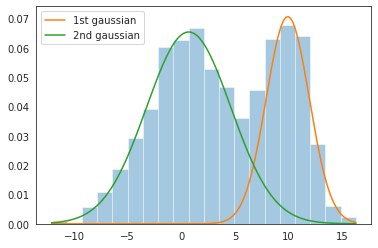

In [24]:
gaussian_1 = stats.norm(mu_1, std_1).pdf(x)
gaussian_2 = stats.norm(mu_2, std_2).pdf(x)
sns.distplot(total_sample, bins=20, kde=False, norm_hist=True)
plt.plot(x, gaussian_1*pi_1, label='1st gaussian')
plt.plot(x, gaussian_2*pi_2, label='2nd gaussian')
plt.legend()